In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC  # Import de SVM
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline
import joblib
from IPython.display import display

In [2]:
from torch import cuda

# Setup device
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Running on device: {device}")

Running on device: cuda


In [3]:
input_csv = r"C:/Users/Seed/Projects/Travel-Order-Resolver/ai/nlp/dataset/text/text_lang_detector.csv"
df = pd.read_csv(input_csv, sep=";")
df.head()

,sentence,is_not_french
0,Y a -t -il un moyen d 'aller de Montreux -Vieu...,0
1,I would like to travel from culoz to buswiller...,1
2,He lied when he said he didn 't like her .,1
3,?N |ajOLIY6 ;DOM 'mKavLZZnkAi,0
4,a (c }sMyu7 /97 . [ -IA @m k0rN0U,0


In [4]:
def preprocess_data(df):
    X = df['sentence']
    y = df['is_not_french']
    
    return X, y

X, y = preprocess_data(df)

print(X.head())
print(y.head())

0    Y a -t -il un moyen d 'aller de Montreux -Vieu...
1    I would like to travel from culoz to buswiller...
2           He lied when he said he didn 't like her .
3                        ?N |ajOLIY6 ;DOM 'mKavLZZnkAi
4                    a (c }sMyu7 /97 . [ -IA @m k0rN0U
Name: sentence, dtype: object
0    0
1    1
2    1
3    0
4    0
Name: is_not_french, dtype: int64


In [5]:
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(X, y)

print(f"Taille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

Taille de l'ensemble d'entraînement : 1041396
Taille de l'ensemble de test : 260349


In [6]:
# pipeline = make_pipeline(TfidfVectorizer(), SVC(kernel='linear'))
# 
# def train_and_predict(X_train, y_train, X_test):
#     pipeline.fit(X_train, y_train)
# 
#     y_pred = pipeline.predict(X_test)
#     
#     return y_pred, pipeline

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from tqdm import tqdm
import numpy as np

# Remplacez SVC par SGDClassifier pour un entraînement incrémental
pipeline = make_pipeline(TfidfVectorizer(), SGDClassifier(loss='hinge', max_iter=1, warm_start=True))

def train_and_predict_with_progress(X_train, y_train, X_test, n_epochs=10):
    for epoch in tqdm(range(n_epochs), desc="Entraînement"):
        pipeline.fit(X_train, y_train)  # Fit une époque à chaque itération

    y_pred = pipeline.predict(X_test)
    return y_pred, pipeline

y_pred, model = train_and_predict_with_progress(X_train, y_train, X_test)

print("Prédictions sur l'ensemble de test :")
print(y_pred)

Entraînement:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Seed\anaconda3\envs\travel_order\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
Entraînement:  10%|█         | 1/10 [00:07<01:09,  7.69s/it]c:\Users\Seed\anaconda3\envs\travel_order\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
Entraînement:  20%|██        | 2/10 [00:15<01:01,  7.68s/it]c:\Users\Seed\anaconda3\envs\travel_order\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
Entraînement:  30%|███       | 3/10 [00:23<00:54,  7.79s/it]c:\Users\See

Prédictions sur l'ensemble de test :
[0 1 1 ... 0 0 0]


In [7]:
def evaluate_model(y_test, y_pred):
    print("### Classification Report ###")
    print(classification_report(y_test, y_pred))
    
    print("### Accuracy ###")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

evaluate_model(y_test, y_pred)

### Classification Report ###
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    183170
           1       0.99      0.93      0.96     77179

    accuracy                           0.98    260349
   macro avg       0.98      0.96      0.97    260349
weighted avg       0.98      0.98      0.98    260349

### Accuracy ###
Accuracy: 0.9762


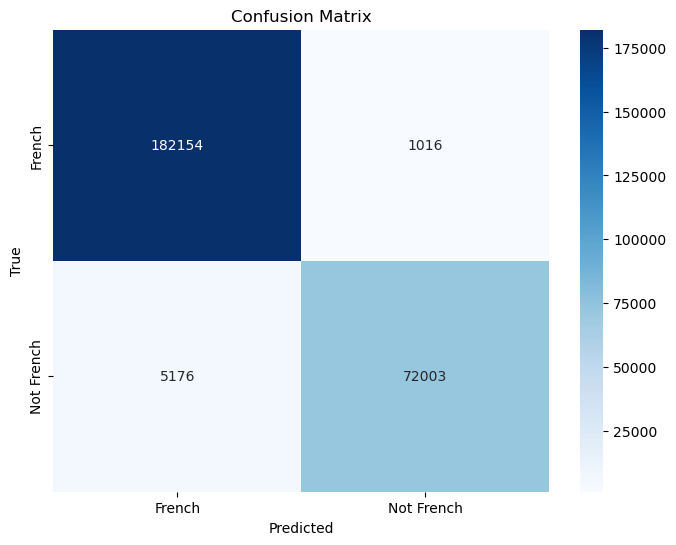

In [8]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["French", "Not French"], yticklabels=["French", "Not French"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

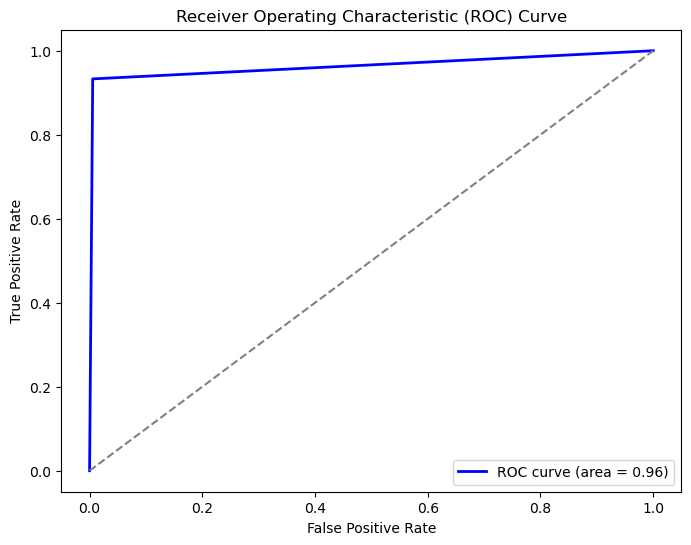

F1 Score: 0.9588
AUC: 0.9637


In [9]:
def plot_metrics(y_true, y_pred):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"AUC: {roc_auc:.4f}")

plot_metrics(y_test, y_pred)

In [11]:
model_path = r"C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\models\text_classification\svm_lang_detection.pkl"
joblib.dump(pipeline, model_path)

print(f"Modèle sauvegardé dans : {model_path}")

Modèle sauvegardé dans : C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\models\text_classification\svm_lang_detection.pkl


In [12]:
new_sentences = [
    "I would like to go to the station.",
    "Voglio andare alla stazione.",
    "je veux partir de Marseille à Paris",
    "Ich möchte zum Bahnhof gehen.",
    "Quiero morir",
    "Je veux aller à la gare."
]

predictions = pipeline.predict(new_sentences)

results = pd.DataFrame({
    'Sentence': new_sentences,
    'Predicted Language': ['French' if prediction == 0 else 'Not French' for prediction in predictions]
})

display(results)

,Sentence,Predicted Language
0,I would like to go to the station.,Not French
1,Voglio andare alla stazione.,Not French
2,je veux partir de Marseille à Paris,French
3,Ich möchte zum Bahnhof gehen.,Not French
4,Quiero morir,French
5,Je veux aller à la gare.,French
